In [16]:
import numpy as np
import sklearn.linear_model as lm
import sklearn.svm as svm
import time as tm
import json
import gc
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
warnings.filterwarnings('ignore')

In [2]:
X_train = np.loadtxt('data/X_train.dat').astype(np.float64)
y_train = np.loadtxt('data/y_train.dat').astype(np.float64)
X_test = np.loadtxt('data/X_test.dat').astype(np.float64)
y_test = np.loadtxt('data/y_test.dat').astype(np.float64)

print(f"X_train.shape {X_train.shape}")
print(f"y_train.shape {y_train.shape}")
print(f"X_test.shape {X_test.shape}")
print(f"y_test.shape {y_test.shape}")


X_train.shape (40000, 32)
y_train.shape (40000,)
X_test.shape (10000, 32)
y_test.shape (10000,)


In [3]:
def my_map(X):
    X = 1-2*X
    X_rev = X[:,::-1]
    X_prod = np.cumprod(X_rev,axis=1)
    X = X_prod[:,::-1]
    
    n_samples, n_features = X.shape
    outer_product = np.einsum('ij,ik->ijk', X, X)
    upper_triangle_indices = np.triu_indices(n_features,k=1)
    features = outer_product[:, upper_triangle_indices[0], upper_triangle_indices[1]]

    result = np.concatenate((X,features),axis=1)

    return result

In [4]:
X_train = my_map(X_train)
X_test = my_map(X_test)

In [5]:
def error_time(model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    '''Return training time in seconds and error % of model over 5 trials'''
    acc=0
    t_train=0
    for i in range(5):
        tic = tm.perf_counter()
        gc.collect()
        model.fit(X_train,y_train)
        w = model.coef_.flatten()
        b = model.intercept_
        toc = tm.perf_counter()
        t_train += toc-tic

        gc.collect()
        scores = X_test.dot( w ) + b
        pred = np.zeros_like( scores )
        pred[scores > 0] = 1
        acc += np.average( y_test == pred )
    
    t_train/=5
    acc/=5

    return (1-acc)*100,t_train


## L1 and L2 for different solvers in logistic regression


In [6]:
solvers = {
    'lbfgs':['l2','None'],
    'liblinear':['l1','l2'],
    'newton-cg':['l2','None'],
    'newton-cholesky':['l2','None'],
    'sag':['l2','None'],
    'saga':['elasticnet','l1','l2','None']
}
errors = {}
times = {}
'''errors{solver:{None:,l2:,l1:}}'''

'errors{solver:{None:,l2:,l1:}}'

In [7]:
for solver in tqdm(solvers.keys()):
    print('\n')
    print(solver)
    penalties = solvers[solver]
    err_dict={}
    time_dict={}
    print('l2')
    if 'l2' in penalties:
        model = lm.LogisticRegression(solver=solver,penalty='l2')
        error,time=error_time(model)
        err_dict['l2'] = error
        time_dict['l2'] = time
    else:
        err_dict['l2'] = 0.0
        time_dict['l2'] = 0.0
    print('l1')
    if 'l1' in penalties:
        model = lm.LogisticRegression(solver=solver,penalty='l1')
        error,time=error_time(model)
        err_dict['l1'] = error
        time_dict['l1'] = time
    else:
        err_dict['l1'] = 0.0
        time_dict['l1'] = 0.0
    print('None')
    if 'None' in penalties:
        model = lm.LogisticRegression(solver=solver,penalty=None)
        error,time=error_time(model)
        err_dict['None'] = error
        time_dict['None'] = time
    else:
        err_dict['None'] = 0.0
        time_dict['None'] = 0.0
    errors[solver] = err_dict
    times[solver] = time_dict
    
        


/Users/architaggarwal/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/architaggarwal/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/architaggarwal/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/architaggarwal/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/architaggarwal/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: T

In [12]:
save_errors_path = 'logs/LR_solvers_penalty_errors.json'
save_times_path = 'logs/LR_solvers_penalty_times.json'
with open(save_errors_path,'w') as f:
    json.dump(errors,f)
with open(save_times_path,'w') as f:
    json.dump(times,f)

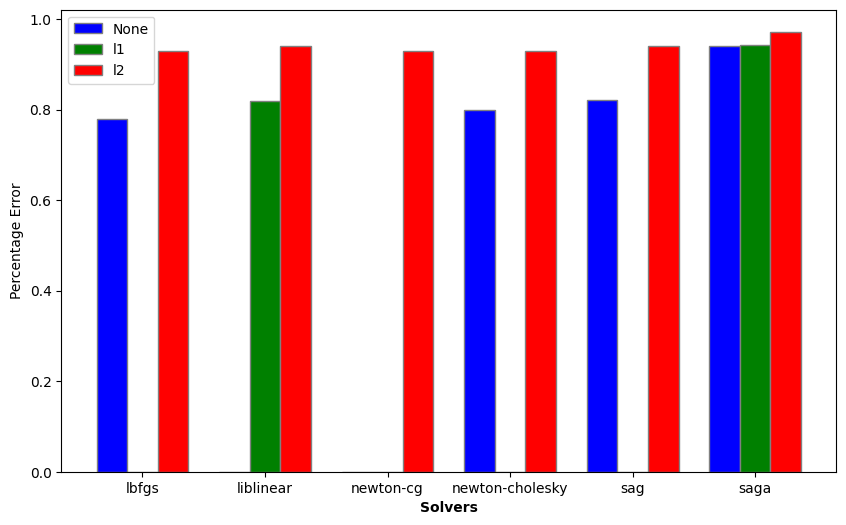

In [30]:
solvers = list(errors.keys())
penalties = ['None', 'l1', 'l2']  
errors['newton-cg']['None'] = 0.0 # for errors>1%

none_errors = [errors[solver]['None'] for solver in solvers]
l1_errors = [errors[solver]['l1'] for solver in solvers]
l2_errors = [errors[solver]['l2'] for solver in solvers]

n = len(solvers)  
r = np.arange(n)  
width = 0.25  

plt.figure(figsize=(10, 6))


plt.bar(r, none_errors, color='b', width=width, edgecolor='grey', label='None')
plt.bar(r + width, l1_errors, color='g', width=width, edgecolor='grey', label='l1')
plt.bar(r + 2*width, l2_errors, color='r', width=width, edgecolor='grey', label='l2')

plt.xlabel('Solvers', fontweight='bold')
plt.xticks([r + width for r in range(n)], solvers)
plt.ylabel('Percentage Error')
plt.legend()

plt.savefig('plots/LR_solvers_penalty_errors.jpg')

plt.show()

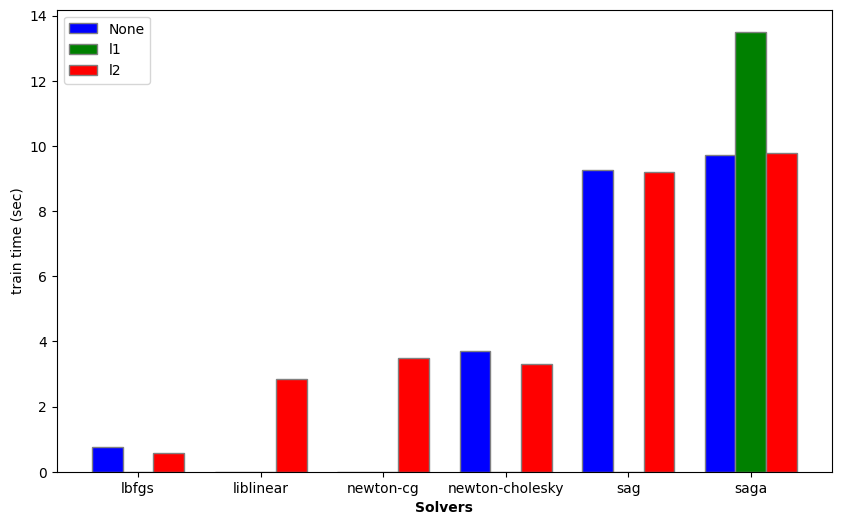

In [29]:
solvers = list(times.keys())
penalties = ['None', 'l1', 'l2']  
# For train_time>20sec
times['newton-cg']['None'] = 0.0
times['liblinear']['l1'] = 0.0

none_errors = [times[solver]['None'] for solver in solvers]
l1_errors = [times[solver]['l1'] for solver in solvers]
l2_errors = [times[solver]['l2'] for solver in solvers]

n = len(solvers)  
r = np.arange(n)  
width = 0.25 

plt.figure(figsize=(10, 6))

plt.bar(r, none_errors, color='b', width=width, edgecolor='grey', label='None')
plt.bar(r + width, l1_errors, color='g', width=width, edgecolor='grey', label='l1')
plt.bar(r + 2*width, l2_errors, color='r', width=width, edgecolor='grey', label='l2')

plt.xlabel('Solvers', fontweight='bold')
plt.xticks([r + width for r in range(n)], solvers)
plt.ylabel('train time (sec)')
plt.legend()

plt.savefig('plots/LR_solvers_penalty_times.jpg')

plt.show()